# Group Assignment QF627

<font size = 5>**Group Members:**</font>
* Anna Germaine Lim
* Chen Pengyu
* Gregory Tan
* Zenith Tay

# Contribution Statement

Name        |Work Contributed                                                                           |
---         |   ---                                                                                     |
Zenith      |Supervised Learning Models and Codes, Report Writing, Team Reflections                           |
Gregory     |   Momentum Trading Strategies and Codes, Report Writing and Collation, Team Reflections             |
Anna        |Mean-Reversion Strategies and Codes, Report Writing, Team Reflections                                |
Pengyu      |Report Writing, Team Reflections, Attempts on unsupervised learning                        |

# Prep Work

## Packages Used in This Workbook

In [ ]:
## Data Download

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as pdr

## For Visualisation

In [ ]:
### For Supervised learning

# Model specification

# linear models
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.linear_model import ElasticNet # Elastic Net
from sklearn.linear_model import Lasso # LASSO

# oldies
from sklearn.svm import SVR # Support Vector Machine
from sklearn.neighbors import KNeighborsRegressor # K-Nearest Neighbor

# decision tree
from sklearn.tree import DecisionTreeRegressor# Decision Tree

# bagging
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import ExtraTreesRegressor # Extra Trees

# boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting Tree
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting

# time-series
import statsmodels.tsa.arima.model as stats # ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Data split
from sklearn.model_selection import train_test_split

# feature engineering

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

## Functions

### Download of Data

In [ ]:
start_date = "2006-11-01"
end_date = "2025-11-13"

In [ ]:
def download_data (ticker: list[str] | str,
                   start_date = start_date, 
                   end_date = end_date,
                   close_only = False) -> pd.DataFrame:
    if close_only == False:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
        )
    else:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
                        ["Close"]
        )    

    return data

In [ ]:
# preallocate empty array and assign slice by chrisaycock

def np_shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

### Mean Reversion Strategies

In [ ]:
def bollinger_band(price_data: pd.Series,
                            window: int = 14,
                                                ) -> pd.Series:

    price = price_data[price_col]

    std_dev_series =\
    (
        price
        .rolling(window = window)
        .std()
    )

    price_high =\
    (
        price + 2*std_dev_series
    )

    price_low =\
    (
        price - 2*std_dev_series
    )

    return price_high, price_low

### Momentum

In [ ]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [ ]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [ ]:
## Generate Moving Avg Cross Signal

def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [ ]:
## ROC

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [ ]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [ ]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

### Performance Metrics

In [ ]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

In [ ]:
## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

In [ ]:
### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd


### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

In [ ]:
def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

In [ ]:
def generate_returns(price_data: pd.DataFrame,
                     price_col: 'str' = 'Close') -> pd.Series:
    
    returns_series = price_data[price_col].pct_change()
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = float(cum_returns_series.iloc[-1].iloc[0])

    print('=== Summary of Returns === \n',
          f'Total Returns = {tot_returns: .2%}'
          )

    return tot_returns, returns_series, cum_returns_series

## Download Dataset

In [ ]:
spy_data =\
(
    download_data("SPY", start_date, end_date)
)
spy_data

In [ ]:
spy_data = \
    (
        spy_data
        .droplevel(
            level = 1,
            axis =1
        )
    )

# Part 1 and 2: Analysis, Visualisation and Strategy

Data Wrangling and Preparation

In [ ]:
train_pct = 0.75
train_test_split_index = int(train_pct*len(spy_data))
spy_train_data =\
    (
        spy_data
        .copy()
        .iloc[ : train_test_split_index]
    )

spy_test_data =\
    (
        spy_data
        .copy()
        .iloc[train_test_split_index : ]
    )

In [ ]:
len(spy_train_data) + len(spy_test_data)

In [ ]:
display(spy_train_data, spy_train_data)

## (1A) Momentum Trading Strategy

### Functions to Generate Positions and Signals

In [ ]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [ ]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [ ]:
def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [ ]:
## Rate of Change

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

In [ ]:
def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [ ]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

In [ ]:
def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [ ]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

In [ ]:
def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

### Functions to Generate Metrics

In [ ]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd

### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

### Evaluate Returns in Totality

def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

### Download Dataset

In [ ]:
train_proportion = 0.75

spy_data =\
(
    download_data('SPY',
                  start_date = '2006-11-01',
                  end_date = '2025-11-12')
    .droplevel(level = 1,
               axis = 1)
    [['Close', 'Volume']]
).resample('W-FRI').agg({'Close': 'last', 'Volume': 'sum'})

spy_train_data = spy_data[:int(train_proportion*len(spy_data))]

spy_data_close = spy_train_data['Close'].to_frame()
spy_data_returns = spy_train_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

In [ ]:
evaluate_returns(spy_data_returns['Returns'], to_print=True)

### FI Train (No Luck)
FI Signals attempted to include volume to indicate strength of the turn. However for indication of trends, not very useful

In [ ]:
time_periods = np.arange(10, 201, 10).tolist()

In [ ]:
def generate_fi_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:

        data = spy_data_returns.copy()
        
        data[f'fi{i}'] = generate_force_index(spy_data['Close'], spy_data['Volume'], i)
        
        data = pd.concat([data, generate_force_index_signal(data[f'fi{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['FI_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'FI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [ ]:
generate_fi_Metrics(list(range(10,251,10))).sort_values(by = 'Annualised Sharpe', ascending=False)

### ROC (No Luck)
ROC Signals Significantly Underperformed the Market

In [ ]:
def generate_ROC_Metrics(time_periods):

    ROC_Metrics = pd.DataFrame()

    for i in time_periods:
        roc_data = spy_data_returns.copy()
        
        roc_data[f'ROC{i}'] = generate_rate_of_change(spy_data_close['Close'], i)
        roc_data = pd.concat([roc_data, generate_rate_of_change_signal(roc_data[f'ROC{i}'])], axis = 1)
        roc_data['Strat_returns'] = roc_data['Returns'] * roc_data['ROC_Position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        roc_series = evaluate_returns(roc_data['Strat_returns'])
        roc_series.name = f'ROC{i}'
        
        ROC_Metrics = pd.concat([ROC_Metrics, roc_series], axis = 1)

    ROC_Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ROC_Metrics.T

In [ ]:
generate_ROC_Metrics(time_periods).sort_values(by = 'Annualised Sharpe', ascending=False)

### RSI (No Luck Either)

In [ ]:
def generate_RSI_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:
        data = spy_data_returns.copy()
        
        data[f'RSI{i}'] = generate_RSI(spy_data_close['Close'], i)
        
        data = pd.concat([data, generate_rsi_signal(data[f'RSI{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['rsi_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'RSI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [ ]:
generate_RSI_Metrics(range(10, 252, 10)).sort_values(by = 'Annualised Sharpe', ascending = False)

### MA and EMA
Moving Average Crossovers seem more promising from the 10 years of data data

In [ ]:
MA_list =\
(
    list(range(10, 201, 10))
) 

In [ ]:
def generate_ema_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()
    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_EMA(ma_cross_data['Close'], i)             
                long_ma_cross_data = generate_EMA(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'EMA{i} + EMA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T

In [ ]:
generate_ema_cross_metrics(MA_list, MA_list).sort_values(by = 'Annualised Sharpe', ascending=False).head(10)

In [ ]:
def generate_ma_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()

    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], i)
                long_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'MA{i} + MA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T, ma_cross_returns

In [ ]:
ma_cross_summary = generate_ma_cross_metrics(MA_list, MA_list)[0]
ma_cross_summary.sort_values(by = 'Total Returns', ascending = False).head(10)

### Test Dataset
Moving Average Was tested against benchmark, with allowance of test data to spillover into training data to allow the Moving Average to Generate Signals at the start of the test

In [ ]:
row = 160

spy_test_data = spy_data[int(train_proportion*len(spy_data)-row):]

spy_data_close = spy_test_data['Close'].to_frame()
spy_data_returns = spy_test_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

# display(spy_test_data[row:])

evaluate_returns(spy_data_returns.loc[spy_data_returns.index[row:],'Returns'], to_print=True);

In [ ]:
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True)

In [ ]:
print('== Strategy Return of MA ==')
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True);

print('\n')

print('== Benchmark Returns ==')
evaluate_returns(spy_data_returns.loc[spy_data_returns.index[160:],'Returns'], to_print=True);

## (1B) Mean Reverting Strategy

In [ ]:
def setup_bollinger_strategy(
        old_df: pd.DataFrame,
        period: int,
        std_dev: int
) -> pd.DataFrame:
    df = old_df.copy()

    df[f'sma_{period}'] = \
    (
        df['Close']
        .rolling(period)
        .mean()
    )

    df['std_dev'] = \
    (
        df['Close']
        .rolling(period)
        .std()
    )

    df[f'upper_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] +
        (
            df['std_dev'] * std_dev
        )
    )

    df[f'lower_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] -
        (
            df['std_dev'] * std_dev
        )
    )

    return df

In [ ]:
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2).iloc[:,-2:]
                             .plot()
)

In [ ]:
spy_train_data_bollinger = \
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2)
)

In [ ]:
def generate_signals(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    
    signal = 0

    lst_signal = []

    for index, item in enumerate(df['Close']):
        if index ==0:
            lst_signal.append(0)
            continue
        prev_close = df['Close'].iloc[index-1] 
        close = df['Close'].iloc[index] 
        sma = df['sma_20'].iloc[index]
        lower_band = df['lower_band_2sd'].iloc[index]
        upper_band = df['upper_band_2sd'].iloc[index]

        if signal == 0:
            if (prev_close < lower_band) & (close > lower_band):
                signal = 1
            if (prev_close > upper_band) & (close < upper_band):
                signal = -1
        

        if signal == -1:
            if close < sma:
                signal = 0
        
        if signal == 1:
            if close > sma:
                signal = 0
        lst_signal.append(signal)

    df['signal'] = lst_signal
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [ ]:
spy_train_data_bollinger = \
(
    generate_signals(spy_train_data_bollinger)
)

In [ ]:
spy_train_data_bollinger

In [ ]:
def compute_strategy_return(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()


    df['daily_return'] = \
    (
        (
            df['Close']/
            df['Close'].shift(1)
        )
        .apply(np.log)
    )

    df['cum_return'] = \
    (
        df['daily_return']
        .cumsum()
        .apply(np.exp)
    )

    df['strategy_return'] = \
    (
        (
            df['position'] 
            *
            df['daily_return']
        )
        .cumsum()
        .apply(np.exp)
    )

    return df

In [ ]:
spy_train_data_bollinger = \
(
    compute_strategy_return(spy_train_data_bollinger)
)

In [ ]:
spy_train_data_bollinger[['strategy_return']].plot()

In [ ]:
spy_train_data_bollinger[['Close','upper_band_2sd','lower_band_2sd']][:100].plot()

In [ ]:
def compute_drawdown(old_df:pd.DataFrame) -> pd.DataFrame:
    df = old_df.copy()

    df['cum_max'] =\
    (
        df['strategy_return']
        .cummax()
    )

    df['drawdown'] = \
    (
        df['cum_max'] -
        df['strategy_return']
    )
    df['in_drawdown'] =\
    (
        df['cum_max'] !=
        df['strategy_return']
    )
    
    return df

In [ ]:
spy_train_data_bollinger = \
    (
        compute_drawdown(spy_train_data_bollinger)
    )

In [ ]:
spy_train_data_bollinger.iloc[-1]

In [ ]:
#Run back Testing on Test data
spy_test_data_bollinger = \
(
    setup_bollinger_strategy(spy_test_data,
                            20,
                            2)
)

In [ ]:
spy_test_data_bollinger =\
(
    spy_test_data_bollinger
    .pipe(generate_signals)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
spy_test_data_bollinger

### Result: Bollinger

In [ ]:
spy_test_data_bollinger[['strategy_return','cum_max']].plot()
spy_train_data_bollinger[['strategy_return','cum_max']].plot()

In [ ]:
(spy_test_data_bollinger.iloc[-1,-4] 
-1
*100)

In [ ]:
print(
    'Test Return (%): ',(spy_test_data_bollinger.iloc[-1,-4]-1) *100,'\n'
    'Train Return (%): ',(spy_train_data_bollinger.iloc[-1,-4] -1) *100)

In [ ]:
#Parameter Tuning: Bollinger Squeeze; Band Expansion; Breakout

#### Momentum Trading Strategy - RSI with MACD

In [ ]:
def RSI(old_df, period=14):
    df = old_df.copy()
    delta = df['Close'].diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    df['rsi'] = 100 - 100 / (1 + rs)
    return df

In [ ]:
def macd(old_df,
        macd_long: int = 26,
        macd_short: int = 12
        ) -> pd.DataFrame:
    
    #MACD - for trend direction
    
    df = old_df.copy()
    
    df['macd_long'] = \
    (    
        df['Close']
        .ewm(span = macd_long,
                adjust = False)
        .mean()
    )

    df['macd_short'] = \
    (
        df['Close']
        .ewm(span = macd_short,
             adjust = False)
        .mean()
    )

    df['macd'] = \
    (
        df['macd_short'] -
        df['macd_long']
    )

    df['signal_line'] = \
    (
        df['macd']
        .ewm(span = 9,
             adjust = False)
        .mean()
    )
    return df


In [ ]:
def generate_signals_rsi_macd(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    df['signal'] = \
    (
        np
        .select(
            [
                (df['rsi'] > 30) & (df['macd'] > df['signal_line']),
                (df['rsi'] < 70) & (df['macd'] < df['signal_line'])
            ],
            [
                1,
                -1
            ],
            0
        )
    )
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [ ]:
spy_train_data_rsi_macd =\
(
    spy_train_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
spy_test_data_rsi_macd = \
(
    spy_test_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [ ]:
spy_test_data_rsi_macd[['cum_return','strategy_return']].plot()

In [ ]:
def setup_buy_new_high(
        old_df,
        num_long_entry:int,
        num_short_entry: int,
        num_long_exit:int,
        num_short_exit: int) -> pd.DataFrame:
    
    df = old_df.copy()

    df['delta'] =\
    (
        df['Close']
        .diff()
    )

    df['up_trend'] =\
    (
        (
            df['delta'] > 0
        )
        .astype(int)
    )

    df['down_trend'] =\
    (
        (
            df['delta'] < 0
        )
        .astype(int)
    )
    
    #entry
    df['entry_short'] = \
    (
        df['up_trend']
        .rolling(num_short_entry)
        .sum() 
        == 
        num_short_entry
    )

    df['entry_long'] = \
    (
        df['down_trend']
        .rolling(num_long_entry)
        .sum() 
        == 
        num_long_entry
    )

    df['exit_short']  = \
    (
        df['down_trend']
        .rolling(num_short_exit)
        .sum() 
        == 
        num_short_exit
    )

    df['exit_long']  = \
    (
        df['up_trend']
        .rolling(num_long_exit)
        .sum() 
        == 
        num_long_exit
    )

    signals = []
    signal = 0

    for short_entry, long_entry, short_exit, long_exit in zip(
        df['entry_short'], 
        df['entry_long'],
        df['exit_short'], 
        df['exit_long']
    ):

        if signal == 0:
            if short_entry:
                signal = -1
            if long_entry:
                signal = 1

        elif signal == 1 and long_exit:
            signal = 0

        elif signal == -1 and short_exit:
            signal = 0

        signals.append(signal)

    df['signal'] = signals

    #stack buy
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
    )
    return df

In [ ]:
spy_train_data['Close'].plot()

In [ ]:
df_ret = pd.DataFrame()

for entry_l in range(2,10):
    for entry_s in range(2,10):
        for exit_l in range(2,10):
            for exit_s in range(2,10):
                a = spy_train_data.copy()
                a = \
                (
                    setup_buy_new_high(a,entry_l,entry_s,exit_l,exit_s)
                    .pipe(compute_strategy_return)
                    .pipe(compute_drawdown)
                )
                df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
df_ret['buy_and_hold'] = a['cum_return'].copy()

In [ ]:
(df_ret.iloc[-1].sort_values(ascending=False)).head(30)

In [ ]:
a =\
(
    setup_buy_new_high(

        spy_test_data,
        2,
        2,
        4,
        2
    )
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

<Axes: xlabel='Date'>

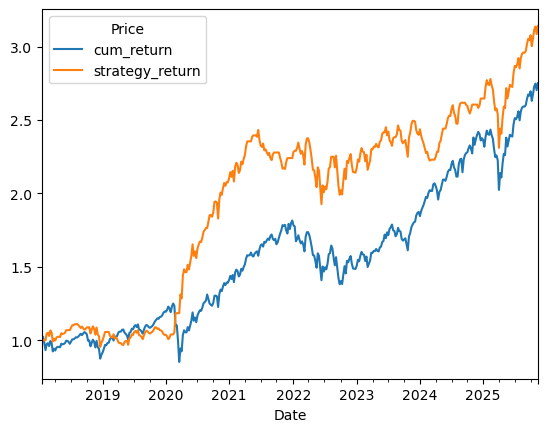

In [84]:
a[['cum_return','strategy_return']].plot()

## (1C) Machine Learning

In [ ]:
stock_ticker = ["META", "AMZN", "AAPL", "NFLX", "GOOG", "SPY"]
forex_ticker = ["DEXUSEU", "DEXJPUS", "DEXUSUK", "DEXSZUS", "DEXCAUS", "DEXUSAL", "DEXUSNZ", "DEXNOUS", "DEXSDUS"]
index_ticker = ["DX-Y.NYB","GC=F", "CL=F", "HG=F", "^VIX"]
yield_ticker = ["^IRX", "^FVX", "^TNX"]

In [ ]:
### download data
stock_data =\
(
    download_data(stock_ticker,
                  close_only = True)
)

forex_data =\
(
    pdr
    .get_data_fred(forex_ticker,
                  stock_data.index[0],
                  stock_data.index[-1])
)

index_data =\
(
    download_data(index_ticker,
                  close_only = True)
)

yield_data =\
(
    download_data(yield_ticker,
                  close_only = True)
)

In [ ]:
index_data = index_data.where(index_data > 0)
index_data = index_data.ffill()

In [ ]:
# technical indicators
technical_data1 = {}
technical_data2 = {}
target_data =\
(
    stock_data.loc[: , "SPY"]
    .copy()
)

In [ ]:
sma_periods = [5, 10, 21, 50, 63, 100, 200, 252, 500]
ema_periods = [5, 10, 21, 50, 63, 100, 200, 252, 500]
rsi_periods = [2, 5, 7, 10, 14, 21, 28]
ROC_periods = [5, 10, 21, 50, 63, 126, 200, 252]        
MOM_periods = [5, 10, 21, 50, 63, 126, 200, 252]         
stochastic_periods = [5, 10, 14, 21]
return_period = 5    

In [ ]:
# sma
for i in sma_periods:
    technical_data1[f"{i}_SMA"] =\
    (
        target_data
        .rolling(window = i)
        .mean()
    )

    # ema
for i in ema_periods:
    technical_data1[f"{i}_EMA"] =\
    (
        target_data
        .ewm(span = i)
        .mean()
    )

# rsi
def RSI(data, period):
    price_diff =\
    (
        data
        .diff()
        .dropna()
    )

    up = price_diff * 0
    down = up.copy()

    up[price_diff > 0] = price_diff[price_diff > 0]
    down[price_diff < 0] = -price_diff[price_diff < 0]

    up[up.index[period - 1]] = np.mean( up[ :period])
    up = up.drop(up.index[ :(period - 1)]
                )
    down[down.index[period - 1]] = np.mean( down[ :period])
    down = down.drop(down.index[ :(period - 1)]
                    )

    rs =\
    (
        up.ewm(com = period - 1,
               adjust = False).mean()
        /
        down.ewm(com = period - 1,
                 adjust = False).mean()
    )

    return 100 - 100 / (1 + rs)
    
for i in rsi_periods:
    technical_data2[f"{i}_RSI"] = RSI(target_data, i)

# RoC
def ROC(data, period):
    M = data.diff(period - 1)
    N = data.shift(period - 1)
    ROC = (M / N) * 100

    return ROC

for i in ROC_periods:
    technical_data2[f"{i}_ROC"] = ROC(target_data, i)   

# Price momentum
def MOM(data, periods):
    MOM = data.diff(periods)
    return MOM
for i in MOM_periods:
    technical_data2[f"{i}_MOM"] = MOM(target_data, i)

# Stochastic Oscillator data
stochastic_oscillator_data =\
(
    yf
    .download("SPY",
              start_date,
              end_date)
    [["Close", "Low", "High"]]
)

stochastic_oscillator_data.columns =\
(
    stochastic_oscillator_data
    .columns
    .droplevel(1)
)

# Stochastic Oscillator
def STOK(df = stochastic_oscillator_data
         , period = 1):
    STOK =\
    (
        ((df["Close"] - df["Low"].rolling(period).min())
        /
        (df["High"].rolling(period).max() - df["Low"].rolling(period).min())
        ) * 100
    )

    return STOK

def STOD(df = stochastic_oscillator_data
         , period = 1):
    STOK =\
    (
        ((df["Close"] - df["Low"].rolling(period).min())
        /
        (df["High"].rolling(period).max() - df["Low"].rolling(period).min())
        ) * 100
    )

    STOD = STOK.rolling(3).mean()
    return STOD

for i in stochastic_periods:
        technical_data2[f"{i}_%K"] = STOK(period = i)
        technical_data2[f"{i}_%D"] = STOD(period = i) 

In [ ]:
# convert to df    
technical_data1 =\
(
    pd
    .DataFrame(technical_data1)
)

technical_data2 =\
(
    pd
    .DataFrame(technical_data2)
)

In [ ]:
# setting of variables
Y =\
(
    np
    .log(stock_data.loc[ : , "SPY"]
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name =\
(
    Y
    .name
    +
    "_pred"
)

In [ ]:
X1 =\
(
    np
    .log(stock_data.loc[ : , ("META", "AMZN", "AAPL", "NFLX", "GOOG")]
        )
    .diff(return_period)   
)

X2 =\
(
    np
    .log(forex_data)
    .diff(return_period)
)

X3 =\
(
    np
    .log(index_data)
    .diff(return_period)
)

X4 =\
(
    yield_data
    .diff(return_period)
    * 100
)

X5 =\
pd.concat(
    [np
     .log(stock_data.loc[ : , "SPY"]
         )
     .diff(i) for i in [return_period,
                        return_period * 3, # 15
                        return_period * 6, # 30
                        return_period * 12 # 60
                       ]
    ],
    axis = 1
).dropna()
X5.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]


X6 =\
(
    np
    .log(technical_data1)
    .diff(return_period)
)

X7 =\
(
    technical_data2
    .diff(return_period)
)



In [ ]:
X =\
(
    pd
    .concat([X1, X2, X3, X4, X5, X6],
           axis =1)
)

X

In [ ]:
data =\
(
    pd
    .concat([Y, X],
           axis = 1)
    .dropna()
)

data =\
(
    data
    .iloc[ : :return_period, : ]
)

In [ ]:
Y =\
(
    data
    .loc[ : ,Y.name]
)

X =\
(
    data
    .loc[ : , X.columns]
)

In [ ]:
testing_set = 0.25

train_size = int(len(X) * (1 - testing_set))

Y_train, Y_test =\
(
    Y[0 : train_size],
    Y[train_size:len(Y)]
)

X_train, X_test =\
(
    X[0: train_size],
    X[train_size:len(X)]
)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

In [ ]:
X_train_scaled =\
    (
        pd
        .DataFrame(
            scaler.transform(X_train),
            index = X_train.index,
            columns = X_train.columns
        )
    )

X_test_scaled =\
    (
        pd
        .DataFrame(
            scaler.transform(X_test),
            index = X_test.index,
            columns = X_test.columns
        )
    )

In [ ]:
models =\
[
    ("LR", LinearRegression()),
    ("Elastic Net Penalty", ElasticNet()),
    ("LASSO", Lasso()),
    ("Support Vector Machine", SVR()),
    ("K-Nearest Neighbors", KNeighborsRegressor()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Extra Trees Algo", ExtraTreesRegressor()),
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("Adaptive Boosting", AdaBoostRegressor())
]

In [ ]:
names = []

train_results = []
test_results = []

kfold_results = []

best_models = {}
ml_equity_curves = {}
results = []
ncomps_list = [5, 10 ,15, 20, 25, 30, 35, 40]

In [ ]:
seed = 627
num_folds = 10
ncomps = 30
metric = "neg_mean_squared_error"

In [ ]:
svd_for_plot = TruncatedSVD(n_components=ncomps, random_state=seed)
svd_for_plot.fit(X_train_scaled)

plt_data = pd.DataFrame(
    svd_for_plot.explained_variance_ratio_.cumsum() * 100,
    index=np.arange(1, ncomps + 1),
    columns=["cum_var_explained"]
)

ax = plt_data.plot(kind="line", figsize=(20, 10), style="o-")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("PCs")
ax.set_ylabel("Percentage Explained")
ax.legend("")

print(
    "Variance preserved by first {} components == {:.2%}".format(
        ncomps,
        svd_for_plot.explained_variance_ratio_.cumsum()[-1]
    )
)

In [ ]:
param_grids =\
{
    "LR":\
    {
        "model__fit_intercept": [True, False]
    },

    "Elastic Net Penalty":\
    {
        "model__alpha": np.logspace(-4, 2, 7),
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "model__max_iter": [5000]
    },

    "LASSO":\
    {
        "model__alpha": np.logspace(-5, 1, 7),
        "model__max_iter": [5000]
    },

    "Support Vector Machine":\
    {
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", "auto"],
        "model__epsilon": [0.001, 0.01, 0.1],
        "model__kernel": ["rbf"]
    },

    "K-Nearest Neighbors":\
    {
        "model__n_neighbors": [3, 5, 9, 15],
        "model__weights": ["uniform", "distance"]
    },

    "Decision Tree":\
    {
        "model__max_depth": [3, 5, 10, None],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },

    "Extra Trees Algo":\
    {
        "model__n_estimators": [100, 300],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__max_features": ["sqrt", None]
    },

    "Random Forest":\
    {
        "model__n_estimators": [150, 300],
        "model__max_depth": [None, 10],
        "model__min_samples_split": [2, 10],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": ["sqrt", None]
    },

    "Gradient Boosting":\
    {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.6, 0.8],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1, 2]
    },

    "Adaptive Boosting":\
    {
        "model__n_estimators": [50, 150],
        "model__learning_rate": [0.05, 0.5],
        "model__loss": ["linear", "square"]
    }
}


In [ ]:
def calculate_ml_results(y_true,
                        y_pred,
                        return_period = return_period,
                        initial_capital = 1e5
                        ):
    data =\
    (
        pd
        .concat(
            [y_true.rename("y_true"),
             y_pred.rename("y_pred")],
             axis = 1
        )
        .dropna()
    )

    signal =\
    (
        np
        .sign(data["y_pred"])   
    )

    position =\
    (
        signal
        .shift(1)
        .fillna(0)
    )

    strategy_returns =\
    (
        position
        *
        data["y_true"]
    )

    equity_curve =\
    (
        np
        .exp(strategy_returns.cumsum())
        *
        initial_capital
    )

    periods_per_year =\
    (
        252
        /
        return_period
    )

    mean_return =\
    (
        strategy_returns
        .mean()
    )

    std_return =\
    (
        strategy_returns
        .std()
    )

    sharpe =\
    (
        mean_return
        /
        std_return
        *
        np.sqrt(periods_per_year)
    )

    n_periods = strategy_returns.shape[0]
    years = n_periods / periods_per_year

    final_equity = equity_curve.iloc[-1]

    cagr =\
    (
        (final_equity / initial_capital) ** (1/ years)
        - 1
    )

    running_max =\
    (
        equity_curve
        .cummax()
    )

    drawdown =\
    (
        equity_curve
        /
        running_max
        - 1
    )

    max_drawdown = drawdown.min()
    
    results =\
    {
        "sharpe": sharpe,
        "cagr": cagr,
        "max_drawdown": max_drawdown,
        "final_equity": final_equity,
        "equity_curve": equity_curve
    }

    return results

In [ ]:
for ncomps in ncomps_list:
    print(f"\n===== Running models for ncomps = {ncomps} =====")

    for name, model in models:

        names.append(f"{name}_nc{ncomps}")

        kfold =\
        (
            KFold(n_splits = num_folds,
                random_state = seed,
                shuffle = True)
        )

        # run SVD
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svd", TruncatedSVD(n_components = ncomps, random_state = seed)),
            ("model", model)
        ])

        param_grid = param_grids.get(name, {})

        grid_search =\
        (
            GridSearchCV(estimator = pipe,
                        param_grid = param_grid,
                        cv = kfold,
                        scoring = metric,
                        n_jobs = -1)
        )

        grid_search.fit(X_train, Y_train)

        res = grid_search.best_estimator_
        best_models[(name, ncomps)] = res
        best_index = grid_search.best_index_

        cv_scores =\
        (
            np
            .array(
                [grid_search.cv_results_[f"split{i}_test_score"][best_index]
                for i in range(num_folds)]
            )
        )
        
        cv_scores = -1 * cv_scores

        kfold_results.append(cv_scores)

        train_result = mean_squared_error(res.predict(X_train), Y_train)
        train_results.append(train_result)

        # Assess the performance in Testing Set

        test_result = mean_squared_error(res.predict(X_test), Y_test)
        test_results.append(test_result)

        y_pred_test =\
        (
            pd
            .Series(res.predict(X_test),
                    index = Y_test.index,
                    name = f"{name}_nc{ncomps}_pred"
                    )
        )

        bt_results =\
        (
            calculate_ml_results(y_true = Y_test,
                                y_pred = y_pred_test)
        )
        
        ml_equity_curves[(name, ncomps)] = bt_results["equity_curve"]

        results.append(
            {
                "Model": name,
                "ncomps": ncomps,
                "CV_MSE_mean": cv_scores.mean(),
                "CV_MSE_std":  cv_scores.std(),
                "Train_MSE":   train_result,
                "Test_MSE":    test_result,
                "Sharpe":      bt_results["sharpe"],
                "CAGR":        bt_results["cagr"],
                "Max_Drawdown":bt_results["max_drawdown"],
                "Final_Equity":bt_results["final_equity"],
                "Best_Params": grid_search.best_params_
            }
        )
        user_interface_message = "%s: %f (%f) %f %f Sharpe=%f CAGR=%f MDD=%f Final=%f" %\
        (
            name, 
            cv_scores.mean(), 
            cv_scores.std(), 
            train_result, 
            test_result,
            bt_results["sharpe"],
            bt_results["cagr"],
            bt_results["max_drawdown"],
            bt_results["final_equity"]
        )
        print(user_interface_message)

In [ ]:
results_df =\
(
    pd
    .DataFrame(results)
    .set_index(["Model", "ncomps"])
).sort_values(by = "Final_Equity",
              ascending = False)

results_df


In [ ]:
from lets_plot import *
LetsPlot.setup_html()

In [ ]:
df_for_plot =\
(
    pd
    .DataFrame(
        {"Algorithms": names * 2,
         "Data": ["Training Set"] * len(names) + ["Testing Set"] * len(names),
         "Performance": train_results + test_results
        }
    )
)


In [ ]:
for (name, ncomps),  fitted_pipe in best_models.items():
    print(f"\n=== Fitting and plotting for model: {name} ===")

    # predict on test set
    y_predictions = fitted_pipe.predict(X_test)

    # Convert predictions to Series aligned with Y_test index
    y_predictions = pd.Series(
        data=y_predictions,
        index=Y_test.index,
        name=f"{name} Predictions"
    )

    # Build cumulative return curves
    actual_results = np.exp(Y_test).cumprod()
    pred_results   = np.exp(y_predictions).cumprod()

    difference = actual_results - pred_results

    # Build DataFrame for plotting
    df_outcome = pd.DataFrame(
        {
            "date": actual_results.index,
            "future SPY": actual_results.values,
            "predicted SPY": pred_results.values,
            "difference": difference.values
        }
    )

    # Long format for lets-plot
    df_outcome_ggplot = df_outcome.melt(
        id_vars=["date", "difference"],
        var_name="series",
        value_name="value"
    )

    # Dynamic y-limit so plots scale nicely
    y_max = float(df_outcome_ggplot["value"].max() * 1.1)

    # Plot using lets-plot
    p = \
    (
        ggplot(df_outcome_ggplot, aes(x="date", y="value", color="series"))
        + geom_line()
        + geom_point()
        + scale_y_continuous(limits=[0, y_max])
        + scale_color_manual(
            values={
                "future SPY": "blue",
                "predicted SPY": "red"
            }
        )
        + ggtitle(f"Predicting SPY Cumulative Returns with {name}")
        + xlab("Date")
        + ylab("Cumulative Returns")
        + theme(legend_position="top")
        + ggsize(1000, 500)
    )

    # show plot for this model
    p.show()


In [ ]:
bh_pred = pd.Series(
    data = 1.0,
    index = Y_test.index,
    name = "buy_and_hold_pred"
)

bh_results = calculate_ml_results(
    y_true = Y_test,
    y_pred = bh_pred,        
    return_period = return_period,
    initial_capital = 1e5    
)

bh_sharpe = bh_results["sharpe"]
bh_cagr = bh_results["cagr"]
bh_mdd = bh_results["max_drawdown"]
bh_final_equity = bh_results["final_equity"]
bh_equity_curve = bh_results["equity_curve"]

print("Buy & Hold SPY (test period)")
print(f"Sharpe:{bh_sharpe:.3f}")
print(f"CAGR:{bh_cagr:.3%}")
print(f"Max Drawdown:{bh_mdd:.2%}")
print(f"Final Balance:{bh_final_equity:,.2f}")

In [ ]:
strategy_name = "Gradient Boosting"
strategy_ncomps = 10

strategy_equity = ml_equity_curves[(strategy_name, strategy_ncomps)]
bh_equity = bh_equity_curve   

df_plot = pd.DataFrame({
    "date": strategy_equity.index,
    "Strategy": strategy_equity.values,
    "Buy_and_Hold": bh_equity.reindex(strategy_equity.index).values
})

df_long = df_plot.melt(
    id_vars="date",
    var_name="series",
    value_name="equity"
)

p =\
(
    ggplot(df_long, aes(x="date", y="equity", color="series"))
    + geom_line()
    + ggtitle(f"Equity Curve: {strategy_name} (ncomps={strategy_ncomps}) vs Buy & Hold SPY")
    + xlab("Date")
    + ylab("Portfolio Value")
    + theme(legend_position="top")
    + ggsize(1000, 500)
)

p.show()

In [ ]:
# Strategy data
row = results_df.loc[(strategy_name, strategy_ncomps)]
st_sharpe = row["Sharpe"]
st_cagr = row["CAGR"]
st_mdd = row["Max_Drawdown"]
st_final_equity = row["Final_Equity"]

# Compute differences (strategy minus buy & hold)
sharpe_diff = st_sharpe - bh_sharpe
cagr_diff_pct = (st_cagr - bh_cagr) * 100 
mdd_diff_pct = (st_mdd - bh_mdd)  * 100
final_equity_diff = st_final_equity - bh_final_equity

print(f"=== Strategy vs Buy & Hold (Test Period) ===")
print(f"Sharpe (Strategy):{st_sharpe:.3f}")
print(f"Sharpe (Buy & Hold):{bh_sharpe:.3f}")
print(f"Sharpe Difference:{sharpe_diff:+.3f}")

print()
print(f"CAGR (Strategy):{st_cagr*100:6.2f}%.")
print(f"CAGR (Buy & Hold):{bh_cagr*100:6.2f}%.")
print(f"CAGR Difference:{cagr_diff_pct:+6.2f}%.")

print()
print(f"Max Drawdown (Strategy):{st_mdd*100:6.2f}%")
print(f"Max Drawdown (B&H):{bh_mdd*100:6.2f}%")
print(f"MDD Difference:{mdd_diff_pct:+6.2f}% ")

print()
print(f"Final Equity (Strategy):{st_final_equity:,.2f}")
print(f"Final Equity (B&H):{bh_final_equity:,.2f}")
print(f"Final Equity Difference:+${final_equity_diff:,.2f}")

# Part 2: Visualisations and Comparisons

**The 3 Strategies**

1. Momentum Trading Strategy: Moving Average

2. Mean-Reverting Strategy:

3. Gradient Boosting Strategy

# Part 3. Executive Summary of Trading Strategies and Backtesting Results

## The 3 Strategies

**The 3 Strategies employed** includes one from each category, with the results compared against the benchmark return from the periods of `11 February 2021` to `12 November 2025`

_Strategy A: (Momentum Trading)_ 


_Strategy B: (Mean-Reversion)_


_Strategy C: (Machine Learning) - Gradient Boosting_



<font size = 4.5>_**Metrics Generated**_</font>

**1. Sharpe Ratio** <br />
Measures risk-adjusted return by scaling the average return by its volatility. A higher Sharpe Ratio indicates that a strategy generates more return per unit of risk.

**2. Compound Annual Growth Rate (CAGR)** <br />
Summarises the long-run growth rate of the portfolio. It captures how quickly wealth compounds over the full sample period.

**3. Maximum and Longest Drawdown (MDD)** <br />
Quantifies the worst peak-to-trough loss experienced by the strategy. This is a key indicator of downside risk and how long the portfolio experiences drawdown, which is not a rational investor with a degree of risk aversion would like to see.


## Strategy A

Strategy A is built on the idea that returns tend to exhibit persistence: strong recent performance can be followed by further gains, while recent weakness can be followed by additional losses. In practice, we construct a momentum signal using past S&P 500 returns over a fixed lookback window. When the recent cumulative return is sufficiently positive, the strategy takes or increases a long position; when the recent cumulative return is sufficiently negative, the strategy either reduces risk or, depending on the rule specification, may take a short position.

The economic intuition is that momentum benefits from extended trending regimes: prolonged bull markets or deep bear markets in which price moves in one direction for some time. Conversely, the strategy is vulnerable to sideways markets with frequent reversals, where trend signals whipsaw and turnover increases.

**Summary of Results**

Portfolio       |   Strategy A      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |

It can be seen that strategy A is almost an exact similar returns. This is because the momentum strategy reflected the economic environment where the SPY continued an upward momentum.

The results show that the strategy effective followed the benchmark return and maintained exposure throughout the test period, converging to a buy-and-hold strategy. Additionally, the use of weekly data up to a short MA of <mark>40 weeks (~1 year)</mark> meant that the moving average would move more meaningfully in the longer term.

## Strategy B

Strategy B takes a contrarian view - instead of betting on trends, it assumes that prices tend to revert towards some “fair value” or medium-term equilibrium. This is operationalised by comparing the current S&P 500 level to a smoothed reference as a normalisation factor. In this case, the use of <mark>indicators insert here </mark>

A typical implementation uses a standardised price change relative to its rolling mean. When the index trades far below its standardised value (a negative z-score), the strategy interprets this as an oversold condition and increases long exposure. When the index trades far above its standardised value (a positive z-score), the strategy treats this as an overbought condition and reduces or even reverses the position.

The intuition is that mean-reversion strategies tend to perform better in choppy or range-bound markets, where deviations from the average are repeatedly corrected.


**Summary of Results**

Portfolio       |   Strategy B      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |

## Strategy C

Strategy C employs a supervised machine learning approach to predict the 5-day forward log returns of the SPY ETF. A panel of models was run using a pipeline of StandScaler and Truncated SVD with the respective hyper-parameter tuning for each model as well as a 10-fold cross-validation. The metric used for training the model was negative mean-squared error. The goal was to get the closest error to 0. The best tuned training models were then tested on a list of Truncated SVD values to see which number of components yielded the best results out-of-sample. The final results were sorted and the model with the best final equity was chosen.

The feature set comprised of:
- MAANG stocks (META, AMZN, AAPL, NFLX, GOOG) as they are large consitutents of the SPY and their moves can drive the overall direction of the index.
- G10 foreign exchange currencies (9 currency pairs) the movement of the currencies can show potential information about potential stock purchase flow as foreigners would have to sell their local currency and buy USD to buy US stocks.
- Commodities and volatility index (DXY, Gold, Crude Oil, Copper, VIX) as broad macro and risk-sentiment indicators to show dollar demand and risk off or risk-off attitudes. broad USD dynamics (DXY), inflation / safe-haven demand (Gold, Oil), global growth / China cycle (Copper, Oil), and overall risk-on / risk-off regimes (VIX).
- Treasury yields (3-month, 5-year, 10-year) to model the shape of the US risk-free curve and market's macro views on interest rate directions which has impact on the US economy and stock market. Also a proxy for monetary policy and the health of the economy. Steepening/flattening, which encodes recession risk vs expansion.
- Multiple lagged SPY returns (5, 15, 30, 60 days) as historical price is supposed to capture most data or information about itself. It reflects the state of the index across different tenors and market states.
- Technical indicators (SMA, EMA, ROC, MOM, RSI, STOK) which gives a compact and diverse summary of trend (SMA,EMA), speed and persistence of moves aka short-to-medium term momentum (ROC, MOM) and mean-reversion pressures seen in local stretch or overbought-oversold conditions (RSI, STOK).

The best model from the backtest led to the use of Gradient Boosting Regression with 10 components for Truncated SVD being employed as Strategy C.

**Summary of Results**:

Portfolio       |   Strategy C      |   Benchmark   |
--              |   --              |      --       |
Sharpe          |   1.58            |   1.09        |
CAGR            |   28.55%          |  19.25%       |
Max Drawdown    | -13.02%           |   -18.25%     |
Final Value     |   $223,071.91     | $175,483.65   |


Over the test period, Strategy C meaningfully outperforms a buy-and-hold SPY benchmark on both risk-adjusted and absolute returns, while also reducing drawdowns.

On a risk-adjusted basis, Strategy C delivers a Sharpe ratio of 1.58, compared with 1.09 for buy-and-hold. This improvement of about +0.49 in the Sharpe ratio shows that Strategy C generates noticeably more return per unit of risk than simply holding SPY.

In terms of growth, Strategy C achieves a CAGR of 28.55%, versus 19.25% for buy-and-hold, an outperformance of +9.30% per year over the test window. This translates into final equity of $223,071.91 for Strategy C versus $175,483.65 for buy-and-hold, i.e. roughly $47,588 more, or about 27% higher terminal wealth from the same starting capital.

From a risk / drawdown perspective, Strategy C also improves the path of returns. Its maximum drawdown is −13.02%, compared with −18.25% for buy-and-hold, a reduction of about 5.2% in peak-to-trough loss. This indicates that Strategy C not only delivers higher returns, but does so with a smoother equity curve and better downside protection than the benchmark.

# Part 4: Self-Critique

**Discussion Point 1: Engaging A 'Purist' Mindset**

> In this project, we initially attempted a first a purist approach to our strategies, focusing on standalone strategies for mean-reversion, momentum trading and machine learning approaches. In a more complex world that has embraced large sets of data and permitted higher frequency of trading, this means that such strategies would not be as profitable as expected.
>
> Additionally, it is highly likely that institutional traders were already on the lookout for such indicators and would crowd out the strategies. An algorithm that is able to blend strategies dynamically could have a better chance at beeting the market

**Discussion Point 2: Robustness versus Overfitting**
>There was an inherent trade off between maintaining a "robust" model vs "Optimisation" of the parameters. In the backtest for strategy A and B, the performances admittedly were tested for the training period leading to models that did well but did not make good trading sense. An example was Moving Average Crossover of periods 50 and 70, where the strategy did beat the market but did not correspond to a numerically significant period.
>
>Another example was the use of Tech stocks as part of the supervised learning model, which was sufficiently representative of the training period of 10 years in a period of tech dominance but might not be necessarily representative for all periods. This means that in the event that the index becomes dominated by constituents other than the tech stocks, the machine learning model might be relevant in 'beating the SPY'.


**Discussion Point 3: Frequency of Trading vs Expected Returns**
> Throughout the assignment, the group had recognised that the strategies had a better chance of beating the market over a longer time-period, hence the employment of weekly data over daily data. This brought up a discussion point on trading frequency and the group's expectation of outperformance of the market.
>
> On one hand, trading more frequently helped the models to differ much more substantially to the market, since it involved taking on and off-loading risk against the benchmark returns. However this required the signals to be a reliable predictor so that it has a higher chance to beat the market. Additionally, the costs of slippage is not accounted for when more trading signals are employed, which makes the models less robust.
>
>On the other hand, trading less frequently ensured that the strategy would be close to the market returns, but reduced significantly the possibility of actually beating the market. Missing certain periods in the markets could also incur large opportunity costs especially if periods of high returns were missed.
>
> The strategies employed hence initially assumed that more signals were better, but has since moved to employing fewer signals (strategy A and C) through employing lower frequency data. This means that in the event of high volatility in the market, these models might be more prone to underperformance since the models mostly sought to follow the market and exit/reverse position when the SPY had a sustained downturn.

**Discussion Point 4: Possible Lookahead Bias**
> For supervised learning models employed, there was a possibility of lookahead bias arising from the use of treasury yield data. This is because treasury yield data are reported ex-ante on some occasions, which is not captured in the backtested data. In future model developments, the models should allow for lagged data to be incorporated into the model and further tested for performance changes.
>
> Therefore, our current backtest is largely an ex-post evaluation of the machine learning strategy. While it provides useful diagnostics, it does not fully capture how the model would have performed ex-ante, using only information available at each decision date. In particular, the extensive model and hyperparameter search across many specifications increases the risk that our ‘best’ model is chosen with the benefit of hindsight, rather than reflecting a truly ex-ante implementable process.
>
> Furthermore in reality, an ex-ante implementation would need a rules-based way to select features (e.g. largest stocks at each point in time, full index universe, or sector indices), rather than hard-coding today’s winners into the model.

**Discussion 5: Simplifying Assumptions in Position Sizing and Execution Logic**

> A further limitation concerns how positions were sized and executed across all strategies. The group adopted a very simplified approach: when a signal is positive, allocate fully into SPY; when negative, allocate to zero. While this is consistent with the requirement to use only SPY as the tradable asset, the binary allocation rule overlooks important considerations.
>
> For one, this approach implicitly assumes frictionless execution. In practice, even with a single asset, execution delays or partial fills would affect realised performance. Our backtest assumes perfect execution at the computed price, which is an idealisation that likely overstates strategy returns.
>
>Second, the lack of position scaling meant that our strategies could not express varying levels of conviction. Signals that were only marginally positive or negative led to the same allocation as strongly trending or strongly reverting conditions. More nuanced sizing rules could have reflected signal strength and improved realism, even within the constraints of the project.
>
>Lastly, the execution timing used in our code did not distinguish clearly between “signal generation at close” and “execution at next open”. This introduces a mild timing bias that makes our strategies appear more reactive than they realistically could be.
>
>These simplifications were practical for completing the assignment efficiently, but they also highlight areas where the implementation could be improved with more careful attention to detail.